In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import proplot as plot

sys.path.append('/Users/46h/Research/code/accphys/')
from tools import envelope_analysis as ea
from tools import plotting as myplt

sys.path.append('/Users/46h/Research/code/accphys/pyorbit/measurement')
from data_analysis import reconstruct

In [2]:
plot.rc['grid.alpha'] = 0.04
plot.rc['figure.facecolor'] = 'white'

In [3]:
def save(figname):
    plt.savefig(''.join(['_output/figures/', figname, '.png']), facecolor='white', dpi=250)

# Quad scan error analysis 

## Load data 

In [4]:
keys = list(np.load('_output/data/keys.npy'))
keys = [key.decode('utf-8') for key in keys]
keydict = {key : i for i, key in enumerate(keys)}
keydict

{'quad tilt angles': 0,
 'twiss mismatch': 1,
 'energy': 2,
 'space charge': 3,
 'beam moments': 4,
 'quad fields': 5}

In [5]:
emittances_list = [np.load('_output/data/emittances_list_{}.npy'.format(i)) for i in range(len(keys) + 1)]
transfer_mats_lists = [np.load('_output/data/transfer_mats_list_{}.npy'.format(i)) for i in range(len(keys) + 1)]
moments_lists = [np.load('_output/data/moments_list_{}.npy'.format(i)) for i in range(len(keys) + 1)]

## Emittances

In [6]:
key = 'quad tilt angles'
i = keydict['quad tilt angles']

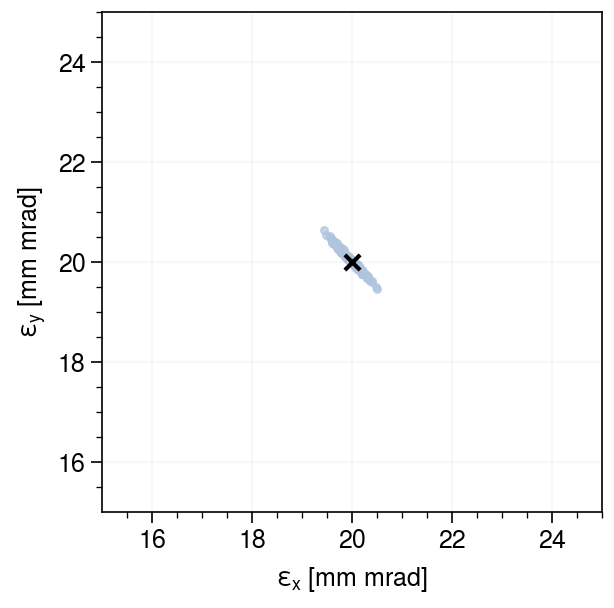

In [7]:
fig, ax = plot.subplots()
emittances = emittances_list[i]
ax.scatter(emittances[:, 2], emittances[:, 3], s=7, c='lightsteelblue', alpha=0.7)
ax.format(
    xlim=(15, 25), ylim=(15, 25),
    xlabel=r'$\varepsilon_x$ [mm mrad]', ylabel=r'$\varepsilon_y$ [mm mrad]'
)
ax.scatter(20.0, 20.0, c='k', marker='x', s=30);

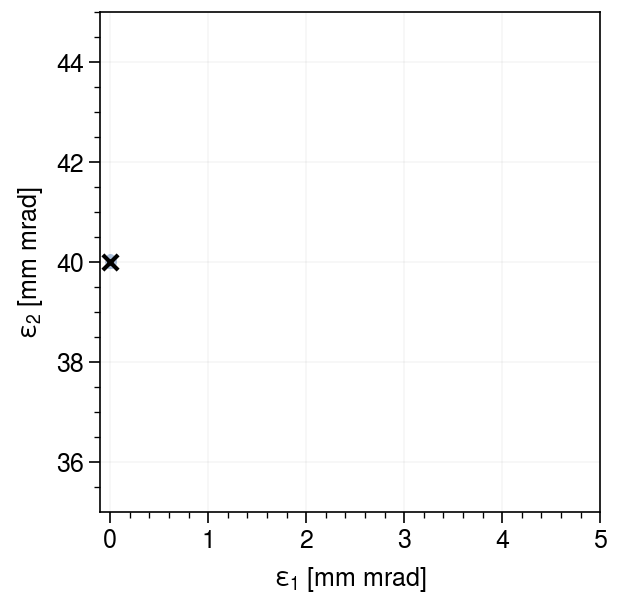

In [8]:
fig, ax = plot.subplots()
emittances = emittances_list[i]
ax.scatter(emittances[:, 0], emittances[:, 1], s=7, c='lightsteelblue', alpha=1)
ax.scatter(0.0, 40.0, c='k', marker='x', s=30);
ax.format(
    xlim=(-0.1, 5), ylim=(35, 45),
    xlabel=r'$\varepsilon_1$ [mm mrad]', ylabel=r'$\varepsilon_2$ [mm mrad]'
)

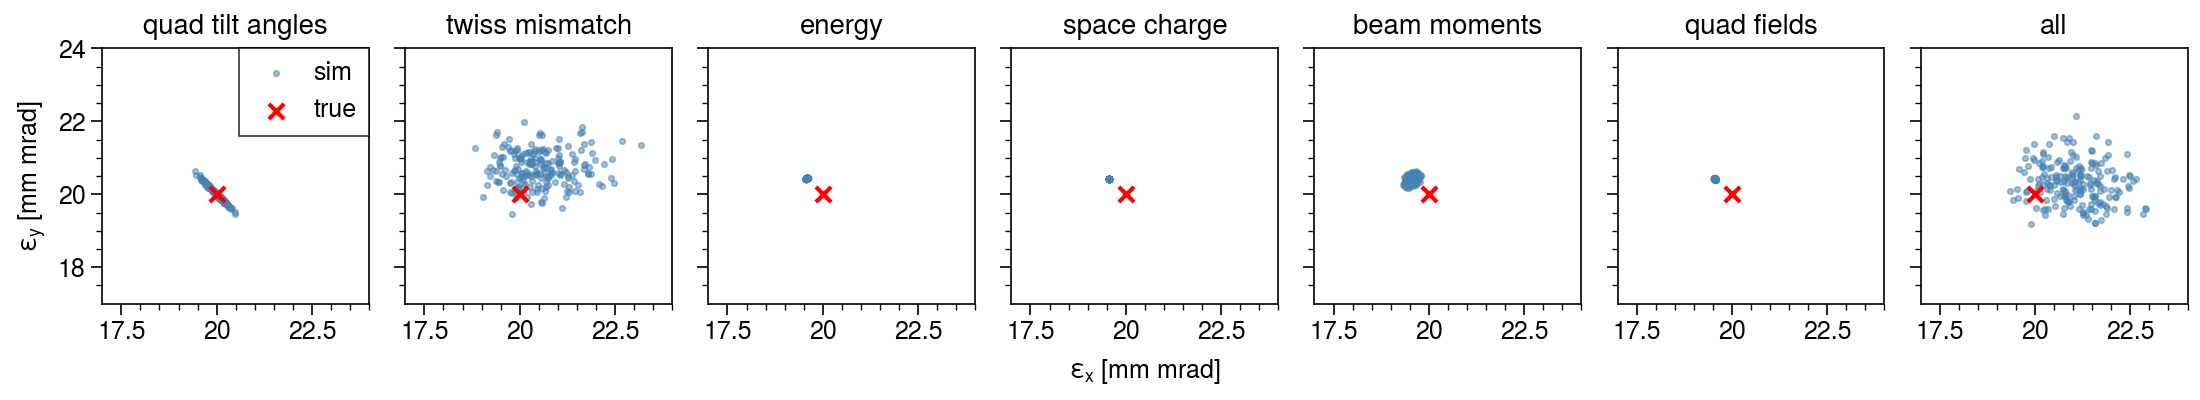

In [9]:
fig, axes = plot.subplots(ncols=len(keys) + 1, figsize=(11, 2))
for i, ax in enumerate(axes):
    emittances = emittances_list[i]
    ax.scatter(emittances[:, 2], emittances[:, 3], s=4, c='steelblue', alpha=0.5)
    ax.scatter(20.0, 20.0, c='r', marker='x', s=30)
    ax.format(title=keys[i] if i < len(keys) else 'all')
lims= (17, 24)
axes.format(xlim=lims, ylim=lims, grid=False, xlabel=r'$\varepsilon_x$ [mm mrad]', ylabel=r'$\varepsilon_y$ [mm mrad]')
axes[0].legend(labels=['sim', 'true'], ncols=1);
save('epsx')

In [10]:
print('means:', np.mean(emittances_list[-1], axis=0))
print('stds: ', np.std(emittances_list[-1], axis=0))

means: [ 0.57415314 40.66399051 21.03852387 20.31149244]
stds:  [0.63224682 1.0382589  0.75414442 0.54925508]


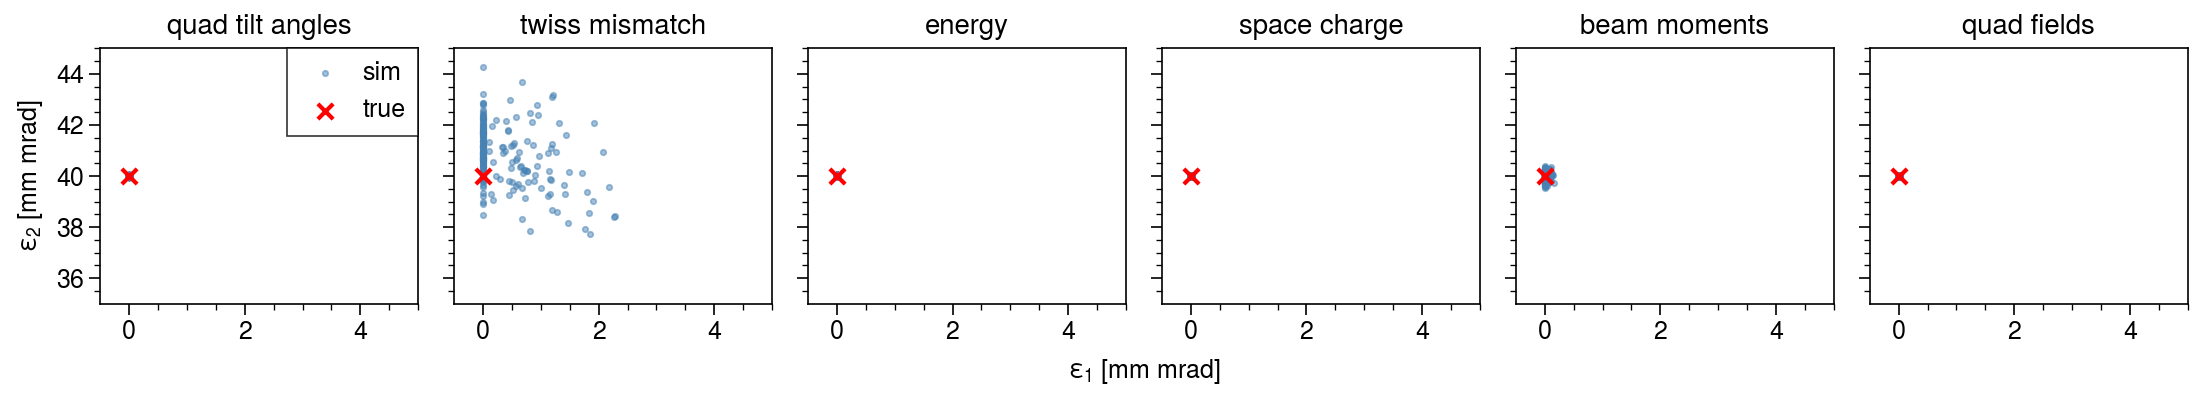

In [19]:
fig, axes = plot.subplots(ncols=len(keys), figsize=(11, 2))
for i, ax in enumerate(axes):
    emittances = emittances_list[i]
    ax.scatter(emittances[:, 0], emittances[:, 1], s=4, c='steelblue', alpha=0.5)
    ax.scatter(0.0, 40.0, c='r', marker='x', s=30);
    ax.format(title=keys[i] if i < len(keys) else 'all')
axes.format(xlim=(-0.5, 5), ylim=(35, 45), grid=False, 
            xlabel=r'$\varepsilon_1$ [mm mrad]', ylabel=r'$\varepsilon_2$ [mm mrad]')
axes[0].legend(labels=['sim', 'true'], ncols=1);
save('eps1')

## Temp 

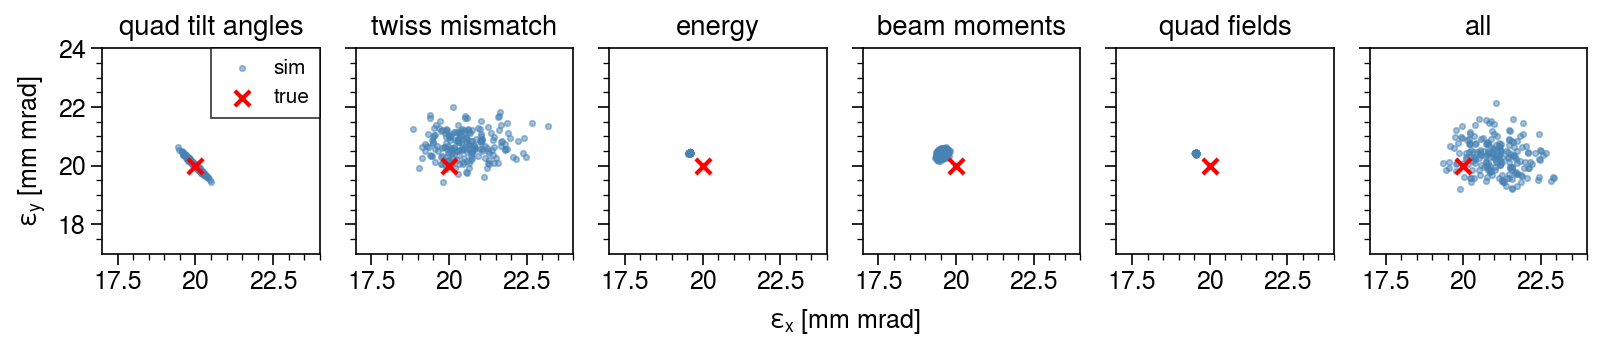

In [23]:
fig, axes = plot.subplots(ncols=6, figsize=(8, 1.75))
for i, ax in zip([0, 1, 2, 4, 5, 6], axes):
    emittances = emittances_list[i]
    ax.scatter(emittances[:, 2], emittances[:, 3], s=4, c='steelblue', alpha=0.5)
    ax.scatter(20.0, 20.0, c='r', marker='x', s=30)
    ax.format(title=keys[i] if i < len(keys) else 'all')
lims= (17, 24)
axes.format(xlim=lims, ylim=lims, grid=False, xlabel=r'$\varepsilon_x$ [mm mrad]', ylabel=r'$\varepsilon_y$ [mm mrad]')
axes[0].legend(labels=['sim', 'true'], ncols=1, fontsize='small');
save('epsx')

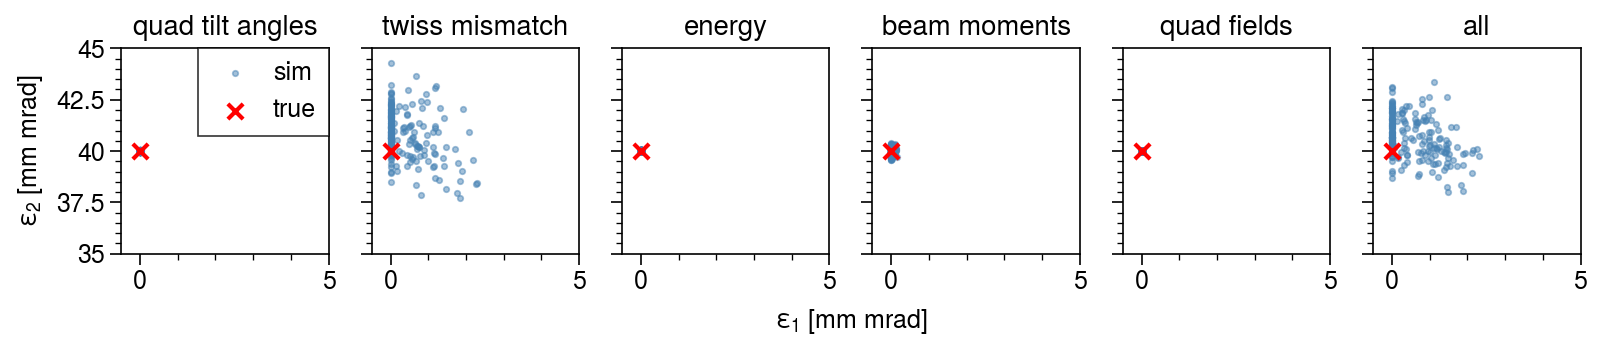

In [25]:
fig, axes = plot.subplots(ncols=6, figsize=(8, 1.75))
for i, ax in zip([0, 1, 2, 4, 5, 6], axes):
    emittances = emittances_list[i]
    ax.scatter(emittances[:, 0], emittances[:, 1], s=4, c='steelblue', alpha=0.5)
    ax.scatter(0.0, 40.0, c='r', marker='x', s=30);
    ax.format(title=keys[i] if i < len(keys) else 'all')
axes.format(xlim=(-0.5, 5), ylim=(35, 45), grid=False, 
            xlabel=r'$\varepsilon_1$ [mm mrad]', ylabel=r'$\varepsilon_2$ [mm mrad]')
axes[0].legend(labels=['sim', 'true'], ncols=1);
save('eps1')

## Visualization using lines

In [12]:
ax0, ay0, bx0, by0 = (-8.082, 4.380, 23.373, 13.455)
scale = 2
epsx = epsy = 20.0
xmax = scale * np.sqrt(epsx)
ymax = scale * np.sqrt(epsy)

def V_2D(alpha, beta):
    return np.array([[beta, 0.0], [-alpha, 1.0]]) / np.sqrt(beta)

def normalize(vec):
    V = np.zeros((4, 4))
    V[:2, :2] = V_2D(ax0, bx0)
    V[2:, 2:] = V_2D(ay0, by0)
    return np.matmul(np.linalg.inv(V), vec)

def get_line_points(M, sig_xx, sig_yy, dim='x', upmin=-10, upmax=10):
    xrms, yrms = np.sqrt(sig_xx), np.sqrt(sig_yy)
    hpts, vpts = [], []
    for up in [upmin, upmax]:
        if dim == 'x':
            vec1 = [xrms, up, 0, 0]
            i, j = 0, 1
        elif dim == 'y':
            vec1 = [0, 0, yrms, up]
            i, j = 2, 3
        vec0 = np.matmul(np.linalg.inv(M), vec1)
        vec0 = normalize(vec0)
        hpts.append(vec0[i])
        vpts.append(vec0[j])
    return hpts, vpts

def plot_lines(ax, transfer_mats, moments, dim='x', **kws):  
    for M, (sig_xx, sig_yy, sig_xy) in zip(transfer_mats, moments):
        hpts, vpts = get_line_points(M, sig_xx, sig_yy, dim)
        ax.plot(hpts, vpts, **kws)
    return ax

In [13]:
i = 6
trial = 0
transfer_mats = transfer_mats_lists[i][trial]
moments = 1e6 * moments_lists[i][trial]

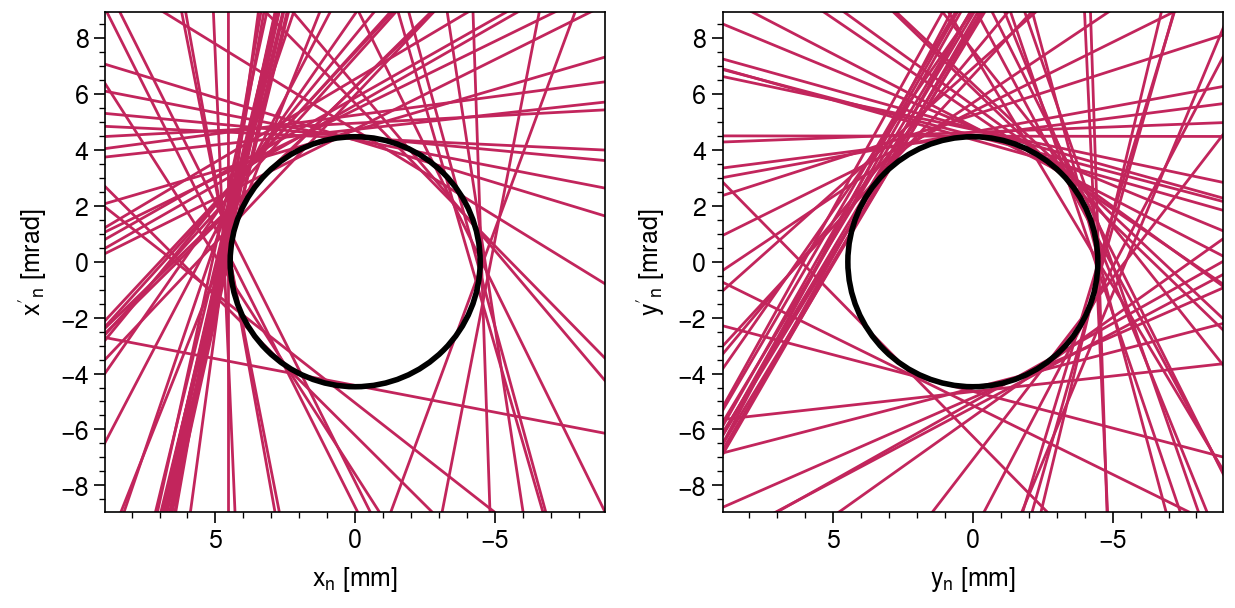

In [16]:
fig, axes = plot.subplots(ncols=2, sharex=False, sharey=False)
axes.format(aspect=1, grid=False)
axes[0].format(xlim=(-xmax, xmax), ylim=(-xmax, xmax), xlabel=r"$x_n$ [mm]", ylabel=r"$x'_n$ [mrad]")
axes[1].format(xlim=(-ymax, ymax), ylim=(-ymax, ymax), xlabel=r"$y_n$ [mm]", ylabel=r"$y'_n$ [mrad]")
myplt.ellipse(axes[0], np.sqrt(epsx), np.sqrt(epsx), lw=2, zorder=999)
myplt.ellipse(axes[1], np.sqrt(epsy), np.sqrt(epsy), lw=2, zorder=999)

nscans = len(transfer_mats)
imid = nscans // 2
imin, imax = 0, -1
kws = dict(color='pink8', lw=1)
plot_lines(axes[0], transfer_mats[imin:imax], moments[imin:imax], 'x', **kws);
plot_lines(axes[1], transfer_mats[imin:imax], moments[imin:imax], 'y', **kws);
save('intrinsic_emittances')

## Plot reconstructed ellipse 

In [356]:
i = 6
trial = np.argmax(emittances_list[-1][:, 0]) # the worst trial
transfer_mats = transfer_mats_lists[i][trial]
moments = 1e6 * moments_lists[i][trial]
Sigma = reconstruct(transfer_mats, moments)

In [357]:
env = ea.Envelope(eps=40.0)
ax0, ay0, bx0, by0 = (-8.082, 4.380, 23.373, 13.455)
env.fit_twiss2D(ax0, ay0, bx0, by0, ex_frac=0.5)
env.set_twiss_param_4D('nu', np.radians(100))

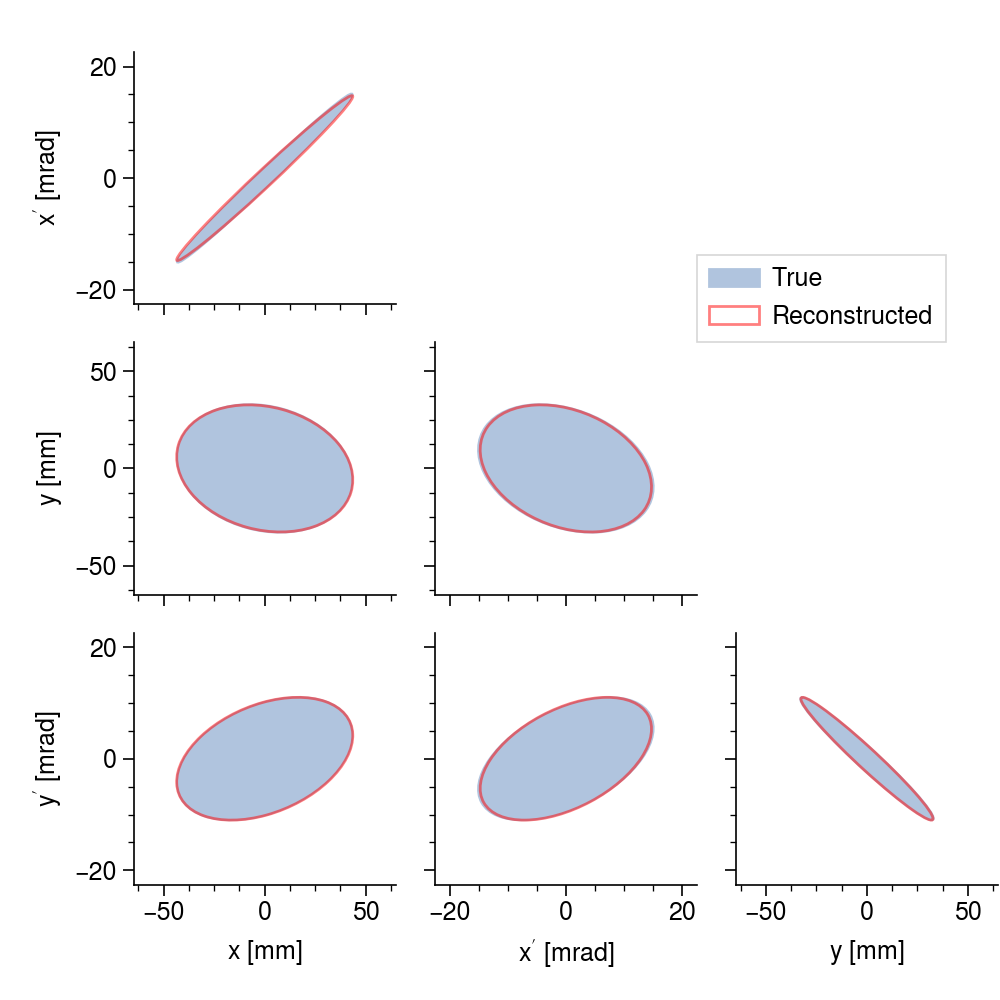

In [367]:
axes = myplt.rms_ellipses(env.cov(), color='lightsteelblue', fill=True, lw=1);
myplt.rms_ellipses(Sigma, axes=axes, color='r', lw=1, fill=False, alpha=0.5);
for i in range(3):
    for j in range(i + 1):
        ax = axes[i, j]
        ax.grid(False)
#         alpha = 0.05
#         ax.axvline(0, color='k', alpha=alpha, zorder=0, lw=1)
#         ax.axhline(0, color='k', alpha=alpha, zorder=0, lw=1)
axes[1, 1].legend(labels=['True', 'Reconstructed'], loc=(1, 1))
save('rec')